# ニューラルネットワークによる将来予測
参考：https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import random
import os


def set_seed(seed=200):
    """
    乱数シードを固定するための関数
    """
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    

## 1.日平均気温データを読み込む

In [3]:
# https://www.data.jma.go.jp/gmd/risk/obsdl/index.php　よりダウンロードした日平均気温を読み込む
df = pd.read_csv('temperature_tokyo_2002-2021.csv', encoding='shift-jis', skiprows=2)

dic_stations = {"東京":"tokyo","名古屋":"nagoya","大阪":"osaka","福岡":"fukuoka"}

# 不要行を落とす
li_col = []
for i in range(df.shape[1]):
    if df.iloc[1,i] in ["品質情報","均質番号"]:
        li_col.append(df.columns[i])
df.drop(columns=li_col, inplace=True)
df.drop(index=[0,1], inplace=True)

# データを整える
df.rename(columns={"Unnamed: 0":"date"}, inplace=True)
df.rename(columns=dic_stations, inplace=True)
df.set_index("date", inplace=True)
df = df.astype(float)
df.index = pd.DatetimeIndex(df.index)

print(df.shape)
display(df.head())
display(df.tail())

(7305, 1)


,tokyo
date,
2002-01-01,7.1
2002-01-02,5.2
2002-01-03,4.1
2002-01-04,6.5
2002-01-05,5.7


,tokyo
date,
2021-12-27,2.7
2021-12-28,3.8
2021-12-29,4.2
2021-12-30,6.5
2021-12-31,3.2


## 2.地点を選択する

,y
date,
2002-01-01,7.1
2002-01-02,5.2
2002-01-03,4.1
2002-01-04,6.5
2002-01-05,5.7


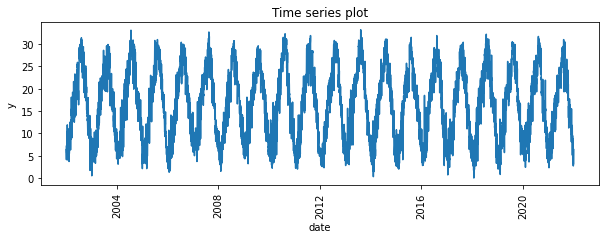

In [4]:
station = "tokyo"
df_y = df[[station]].copy()
df_y.rename(columns={station:"y"}, inplace=True)
display(df_y.head())

# 折れ線グラフ
plt.figure(figsize=(10,3))
fig = sns.lineplot(data=df_y, x="date",  y="y")
plt.xticks(rotation=90)
plt.title("Time series plot")
plt.show()

## 3.部分時系列に変換する

In [5]:
# 窓の大きさを設定する
max_lag = 60

df_Xy = df_y.copy()

# 部分時系列をつくる
for lag in range(1,max_lag+1):
    df_Xy["x%s"%lag] = df_Xy["y"].shift(lag)
df_Xy.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-02,5.2,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-03,4.1,5.2,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-04,6.5,4.1,5.2,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-05,5.7,6.5,4.1,5.2,7.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4.データセットを作る

In [6]:
# 欠損を含む行を削除する
df_Xy.dropna(inplace=True)

X = df_Xy.drop(axis=1, labels="y")
y = df_Xy[["y"]]

display(X.head())
display(y.head())

# 訓練データとテストデータに分ける
X_train = X.loc[:"2020-12-31"]
y_train = y.loc[:"2020-12-31"]
X_test = X.loc["2021-01-01":]
y_test = y.loc["2021-01-01":]

# 標準化
std_X = StandardScaler()
X_train_std = std_X.fit_transform(X_train)
X_test_std = std_X.transform(X_test)
std_y = StandardScaler()
y_train_std = std_y.fit_transform(y_train)
y_test_std = std_y.transform(y_test)

X_train = pd.DataFrame(X_train_std, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(X_test_std, index=X_test.index, columns=X_test.columns)
y_train = pd.DataFrame(y_train_std, index=y_train.index, columns=y_train.columns)
y_test = pd.DataFrame(y_test_std, index=y_test.index, columns=y_test.columns)

# 検証データを作る
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=1234)

# 配列形状を(バッチサイズ, タイムステップ数, 特徴量数） にする
X_train = X_train.values[:, :, np.newaxis]
X_valid = X_valid.values[:, :, np.newaxis]
X_test = X_test.values[:, :, np.newaxis]

display(X_train.shape)
display(X_valid.shape)
display(X_test.shape)
display(y_train.shape)
display(y_valid.shape)
display(y_test.shape)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
date,,,,,,,,,,,,,,,,,,,,,
2002-03-02,12.0,10.3,10.9,9.5,8.3,8.9,10.8,12.5,10.6,9.0,...,8.2,7.5,7.4,4.3,5.6,5.7,6.5,4.1,5.2,7.1
2002-03-03,12.3,12.0,10.3,10.9,9.5,8.3,8.9,10.8,12.5,10.6,...,10.1,8.2,7.5,7.4,4.3,5.6,5.7,6.5,4.1,5.2
2002-03-04,6.3,12.3,12.0,10.3,10.9,9.5,8.3,8.9,10.8,12.5,...,10.4,10.1,8.2,7.5,7.4,4.3,5.6,5.7,6.5,4.1
2002-03-05,8.5,6.3,12.3,12.0,10.3,10.9,9.5,8.3,8.9,10.8,...,10.2,10.4,10.1,8.2,7.5,7.4,4.3,5.6,5.7,6.5
2002-03-06,9.1,8.5,6.3,12.3,12.0,10.3,10.9,9.5,8.3,8.9,...,9.1,10.2,10.4,10.1,8.2,7.5,7.4,4.3,5.6,5.7


,y
date,
2002-03-02,12.3
2002-03-03,6.3
2002-03-04,8.5
2002-03-05,9.1
2002-03-06,10.3


(4816, 60, 1)

(2064, 60, 1)

(365, 60, 1)

(4816, 1)

(2064, 1)

(365, 1)

## 5.計算結果を格納するdictを定義する

In [7]:
performance_train = {}
performance_valid = {}
performance_test = {}

## 6.計算を実行するための関数を定義する

In [8]:
def compile_and_fit(model, X_train, y_train, X_valid, y_valid, patience=2, MAX_EPOCHS=20, learning_rate=0.001,batch_size=32):
    # 早期終了の設定
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    # 学習条件の設定
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                metrics=[tf.metrics.MeanAbsoluteError()])


    
     # 学習の実行
    history = model.fit(
                      x=X_train,
                      y=y_train,
                      batch_size=batch_size,
                      epochs=MAX_EPOCHS,
                      validation_data=(X_valid, y_valid),
                      callbacks=[early_stopping])

    # ネットワーク構造の表示
    print()    
    print(model.summary())
    
    return history

## 7.中間層をもたないニューラルネットワーク（線形回帰と等価）の学習を行う

In [9]:
# 乱数シードの固定
set_seed(seed=1234)

# モデルの定義
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(units=1)
])

# 学習
history = compile_and_fit(linear, X_train, y_train, X_valid, y_valid, MAX_EPOCHS=100, learning_rate=0.01)

# 評価
performance_train['LINEAR'] = linear.evaluate(X_train, y_train)
performance_valid['LINEAR'] = linear.evaluate(X_valid, y_valid)
performance_test['LINEAR'] = linear.evaluate(X_test, y_test, verbose=0)

Epoch 1/100
151/151 [==============================] - 5s 4ms/step - loss: 0.2241 - mean_absolute_error: 0.3611 - val_loss: 0.1121 - val_mean_absolute_error: 0.2646
Epoch 2/100
151/151 [==============================] - 1s 3ms/step - loss: 0.0982 - mean_absolute_error: 0.2450 - val_loss: 0.0869 - val_mean_absolute_error: 0.2335
Epoch 3/100
151/151 [==============================] - 0s 3ms/step - loss: 0.0784 - mean_absolute_error: 0.2181 - val_loss: 0.0773 - val_mean_absolute_error: 0.2161
Epoch 4/100
151/151 [==============================] - 1s 4ms/step - loss: 0.0712 - mean_absolute_error: 0.2082 - val_loss: 0.0741 - val_mean_absolute_error: 0.2102
Epoch 5/100
151/151 [==============================] - 0s 3ms/step - loss: 0.0713 - mean_absolute_error: 0.2079 - val_loss: 0.0665 - val_mean_absolute_error: 0.1991
Epoch 6/100
151/151 [==============================] - 1s 5ms/step - loss: 0.0677 - mean_absolute_error: 0.2021 - val_loss: 0.0678 - val_mean_absolute_error: 0.2063
Epoch 7/10

## 8.全結合型ニューラルネットワークの学習を行う

In [10]:
# 乱数シードの固定
set_seed(seed=1234)

# モデルの定義
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=16, activation='relu'),       
    tf.keras.layers.Dense(units=16, activation='relu'),    
    tf.keras.layers.Dense(units=8, activation='relu'),      
    tf.keras.layers.Dense(units=8, activation='relu'),         
    tf.keras.layers.Dense(units=1)
])

# 学習
history = compile_and_fit(dense, X_train, y_train, X_valid, y_valid, MAX_EPOCHS=100, learning_rate=0.001,batch_size=16)
_
# 評価
performance_train['DENSE'] = dense.evaluate(X_train, y_train)
performance_valid['DENSE'] = dense.evaluate(X_valid, y_valid)
performance_test['DENSE'] = dense.evaluate(X_test, y_test, verbose=0)

Epoch 1/100
301/301 [==============================] - 3s 4ms/step - loss: 0.2385 - mean_absolute_error: 0.3685 - val_loss: 0.1058 - val_mean_absolute_error: 0.2578
Epoch 2/100
301/301 [==============================] - 1s 4ms/step - loss: 0.0971 - mean_absolute_error: 0.2442 - val_loss: 0.0969 - val_mean_absolute_error: 0.2460
Epoch 3/100
301/301 [==============================] - 1s 4ms/step - loss: 0.0885 - mean_absolute_error: 0.2332 - val_loss: 0.0879 - val_mean_absolute_error: 0.2334
Epoch 4/100
301/301 [==============================] - 1s 3ms/step - loss: 0.0809 - mean_absolute_error: 0.2225 - val_loss: 0.0823 - val_mean_absolute_error: 0.2257
Epoch 5/100
301/301 [==============================] - 1s 4ms/step - loss: 0.0758 - mean_absolute_error: 0.2154 - val_loss: 0.0795 - val_mean_absolute_error: 0.2201
Epoch 6/100
301/301 [==============================] - 1s 4ms/step - loss: 0.0718 - mean_absolute_error: 0.2087 - val_loss: 0.0782 - val_mean_absolute_error: 0.2231
Epoch 7/10

## 9.畳み込みニューラルネットワークの学習を行う

In [11]:
# 乱数シードの固定
set_seed(seed=1234)
    
# モデルの定義
conv = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=28,
                           kernel_size=(4,),
                           activation='relu',
                           dilation_rate=1,
                           padding="valid",
                          ),  
    tf.keras.layers.Conv1D(filters=28,
                           kernel_size=(4,),
                           activation='relu',
                           dilation_rate=1,
                           padding="valid",
                          ),      
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

# 学習
history = compile_and_fit(conv, X_train, y_train, X_valid, y_valid, MAX_EPOCHS=100, learning_rate=0.001,patience=3,batch_size=32)

# 評価
performance_train['CONV'] = conv.evaluate(X_train, y_train)
performance_valid['CONV'] = conv.evaluate(X_valid, y_valid)
performance_test['CONV'] = conv.evaluate(X_test, y_test, verbose=0)

Epoch 1/100
151/151 [==============================] - 8s 6ms/step - loss: 0.1418 - mean_absolute_error: 0.2948 - val_loss: 0.1051 - val_mean_absolute_error: 0.2583
Epoch 2/100
151/151 [==============================] - 1s 5ms/step - loss: 0.0957 - mean_absolute_error: 0.2425 - val_loss: 0.0945 - val_mean_absolute_error: 0.2418
Epoch 3/100
151/151 [==============================] - 1s 5ms/step - loss: 0.0779 - mean_absolute_error: 0.2174 - val_loss: 0.0743 - val_mean_absolute_error: 0.2100
Epoch 4/100
151/151 [==============================] - 1s 5ms/step - loss: 0.0684 - mean_absolute_error: 0.2031 - val_loss: 0.0718 - val_mean_absolute_error: 0.2047
Epoch 5/100
151/151 [==============================] - 1s 7ms/step - loss: 0.0646 - mean_absolute_error: 0.1976 - val_loss: 0.0677 - val_mean_absolute_error: 0.2042
Epoch 6/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0637 - mean_absolute_error: 0.1956 - val_loss: 0.0762 - val_mean_absolute_error: 0.2152
Epoch 7/10

## 10.再帰型ニューラルネットワークの学習を行う

In [12]:
# 乱数シードの固定
set_seed(seed=1234)

# モデルの定義
lstm = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True),
    # return_sequences=True：すべての特徴量を採用する
    # return_sequences=False：最後の特徴量だけを採用する    

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# 学習
history = compile_and_fit(lstm, X_train, y_train, X_valid, y_valid, MAX_EPOCHS=100, learning_rate=0.001,batch_size=256)

# 評価
performance_train['LSTM'] = lstm.evaluate(X_train, y_train)
performance_valid['LSTM'] = lstm.evaluate(X_valid, y_valid)
performance_test['LSTM'] = lstm.evaluate(X_test, y_test, verbose=0)

Epoch 1/100
19/19 [==============================] - 8s 219ms/step - loss: 0.2712 - mean_absolute_error: 0.4107 - val_loss: 0.1189 - val_mean_absolute_error: 0.2708
Epoch 2/100
19/19 [==============================] - 4s 239ms/step - loss: 0.1141 - mean_absolute_error: 0.2661 - val_loss: 0.1016 - val_mean_absolute_error: 0.2539
Epoch 3/100
19/19 [==============================] - 5s 260ms/step - loss: 0.1007 - mean_absolute_error: 0.2500 - val_loss: 0.0992 - val_mean_absolute_error: 0.2494
Epoch 4/100
19/19 [==============================] - 4s 206ms/step - loss: 0.0969 - mean_absolute_error: 0.2452 - val_loss: 0.0938 - val_mean_absolute_error: 0.2424
Epoch 5/100
19/19 [==============================] - 5s 243ms/step - loss: 0.0945 - mean_absolute_error: 0.2420 - val_loss: 0.0913 - val_mean_absolute_error: 0.2384
Epoch 6/100
19/19 [==============================] - 4s 195ms/step - loss: 0.0932 - mean_absolute_error: 0.2401 - val_loss: 0.0902 - val_mean_absolute_error: 0.2389
Epoch 7/10

## 11.MSEを比較する

<Figure size 432x144 with 0 Axes>

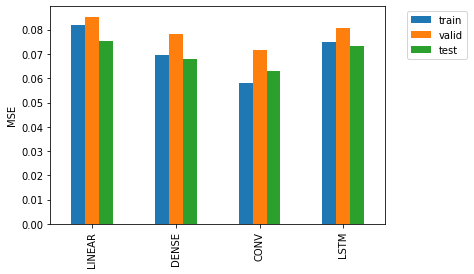

In [13]:
df_train_mse = pd.DataFrame(performance_train, index=["MSE", "MAE"]).T[["MSE"]]
df_train_mse.rename(columns={"MSE":"train"}, inplace=True)
df_valid_mse = pd.DataFrame(performance_valid, index=["MSE", "MAE"]).T[["MSE"]]
df_valid_mse.rename(columns={"MSE":"valid"}, inplace=True)
df_test_mse = pd.DataFrame(performance_test, index=["MSE", "MAE"]).T[["MSE"]]
df_test_mse.rename(columns={"MSE":"test"}, inplace=True)

df_performance = pd.concat([df_train_mse,df_valid_mse, df_test_mse], axis=1)
df_performance = df_performance.loc[["LINEAR","DENSE","CONV","LSTM"]]
plt.figure(figsize=(6,2))
df_performance.plot.bar()
plt.ylabel("MSE")
plt.legend(bbox_to_anchor=(1.05,1.))
plt.show()

## 12.予測性能を評価する

LINEAR
12/12 [==============================] - 0s 1ms/step
RMSE of training data  0.2860084304388953
RMSE of test data  0.27448758811676355


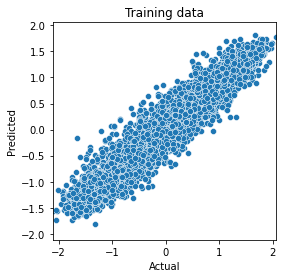

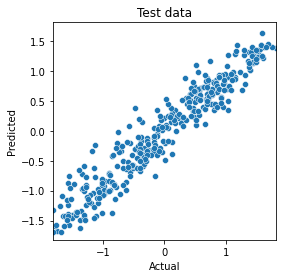

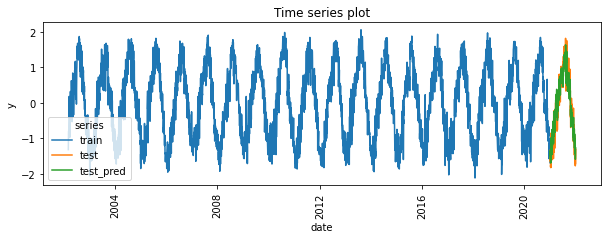

DENSE
12/12 [==============================] - 0s 2ms/step
RMSE of training data  0.26401085870336266
RMSE of test data  0.26076152347687853


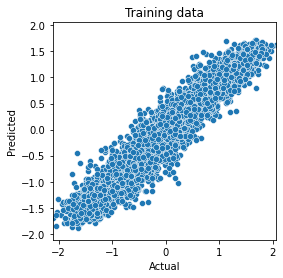

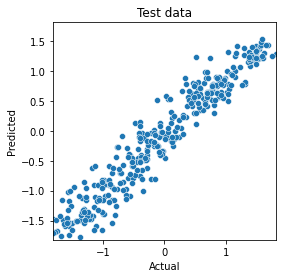

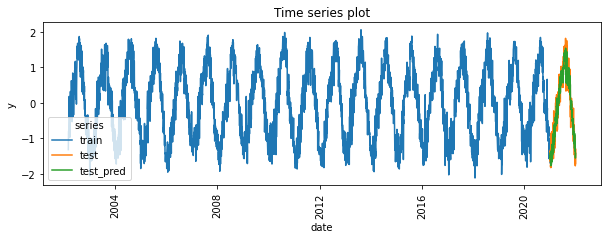

CONV
12/12 [==============================] - 0s 2ms/step
RMSE of training data  0.24115482174501407
RMSE of test data  0.2505346495474569


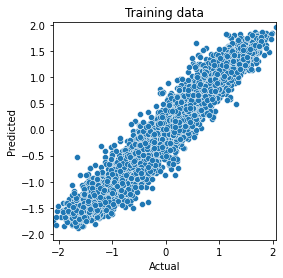

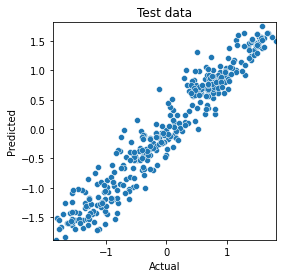

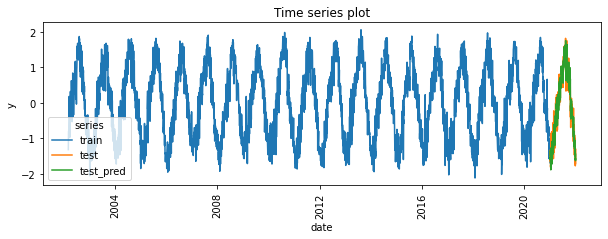

LSTM
12/12 [==============================] - 0s 18ms/step
RMSE of training data  0.2740325152675097
RMSE of test data  0.2710480936105306


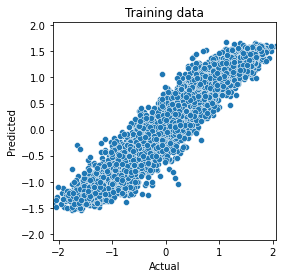

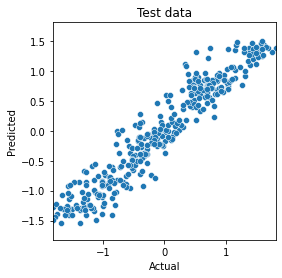

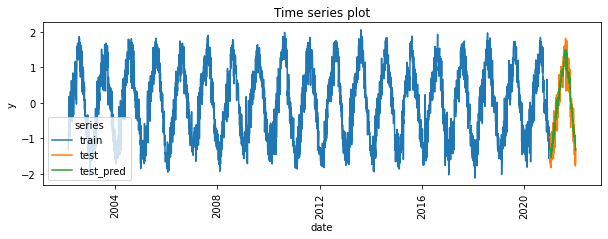

In [14]:
def graph_scatter(y, y_pred, title):  
    """正解と予測の散布図を描くための関数"""    
    y = y["y"].values.flatten()    
    min_ = min(y.min(), y_pred.min())
    max_ = max(y.max(), y_pred.max())
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=y, y=y_pred)
    plt.title(title)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.xlim([min_, max_])
    plt.ylim([min_, max_])
    plt.show()

    
def graph_line(y_train, y_test, y_test_pred):
    """折れ線グラフを描くための関数"""
    df_train = pd.DataFrame(y_train).copy()
    df_test = pd.DataFrame(y_test).copy()
    df_test_pred = pd.DataFrame({"test_pred":y_test_pred}, index=df_test.index).rename(columns={"test_pred":"y"})

    df_train["series"] = "train"
    df_test["series"] = "test"
    df_test_pred["series"] = "test_pred"
    df_result = pd.concat([df_train, df_test, df_test_pred], axis=0).reset_index()

    # 折れ線グラフ
    plt.figure(figsize=(10,3))
    fig = sns.lineplot(data=df_result, x="date", y="y", hue="series")
    plt.xticks(rotation=90)
    plt.title("Time series plot")
    plt.show()
    

def evaluate(model, X_train, X_test, y_train, y_test):    
    """性能評価を行うための関数"""    
    y_train_pred = model.predict(X_train).flatten()
    y_test_pred = model.predict(X_test).flatten()

    # RMSE
    print("RMSE of training data ", mean_squared_error(y_train, y_train_pred)**0.5)
    print("RMSE of test data ", mean_squared_error(y_test, y_test_pred)**0.5)

    # scatter plot, train
    graph_scatter(y_train, y_train_pred, "Training data")

    # scatter plot, test
    graph_scatter(y_test, y_test_pred, "Test data")
    
    # line plot
    graph_line(y_train, y_test, y_test_pred)
        
    return  y_train_pred, y_test_pred

print("="*50)
print("LINEAR")
y_train_pred, y_test_pred = evaluate(linear, X_train, X_test, y_train, y_test)
print("DENSE")
y_train_pred, y_test_pred = evaluate(dense, X_train, X_test, y_train, y_test)
print("CONV")
y_train_pred, y_test_pred = evaluate(conv, X_train, X_test, y_train, y_test)
print("LSTM")
y_train_pred, y_test_pred = evaluate(lstm, X_train, X_test, y_train, y_test)